## Training code for multi-task EQ detection

In [1]:
# import models
from keras.layers import *
from keras.models import Sequential, Model, load_model
from keras import optimizers, losses
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay 
from scipy import fftpack
from keras.optimizers import Adam
import time
import numpy as np
import h5py
import os
import sys
import random
sys.path.insert(1, '../')
from demos.utils import *

# set random seed
seed = 202404
np.random.seed(seed)
tf.random.set_seed(seed)

# # check GPUs
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

# Make a new dir to save the picking error
directory_path = "../training_model/"

# Create the directory, including any necessary parent directories
os.makedirs(directory_path, exist_ok=True)


# Make a new dir to save the picking error
directory_path_1 = "../training_model/logs/"

# Create the directory, including any necessary parent directories
os.makedirs(directory_path_1, exist_ok=True)

2024-11-16 15:01:13.235289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 15:01:13.235318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 15:01:13.236340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 15:01:13.241392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 15:01:13.746963: W tensorflow/compiler/tf2

## Define the attention block

In [2]:
# define hybrids attention model
def channel_attention(input_tensor, reduction_ratio=16):
    channel_avg = GlobalAveragePooling1D()(input_tensor)
    channel_dense1 = Dense(units=int(input_tensor.shape[-1]) // reduction_ratio, activation='relu')(channel_avg)
    channel_dense2 = Dense(units=int(input_tensor.shape[-1]), activation='sigmoid')(channel_dense1)
    channel_attention = Multiply()([input_tensor, Reshape(target_shape=(1, -1))(channel_dense2)])
    return channel_attention

def spatial_attention(input_tensor):
    spatial_avg = Lambda(lambda x: K.mean(x, axis=2))(input_tensor)
    spatial_max = Lambda(lambda x: K.max(x, axis=2))(input_tensor)
    spatial_concat = Reshape(target_shape=(-1, 2))(concatenate([spatial_avg, spatial_max],axis=1))
    spatial_conv1 = Conv1D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(spatial_concat)
    spatial_attention = Multiply()([input_tensor, Reshape(target_shape=(-1, 1))(spatial_conv1)])
    return spatial_attention

def cbam_block(input_tensor):
    channel_att = channel_attention(input_tensor)
    spatial_att = spatial_attention(channel_att)
    cbam_output = Add()([channel_att, spatial_att])
    return cbam_output

## Define data path

In [3]:
# IDs for classification
Clas_signal_id_path = '../data/txed_signal_id.npy'
Clas_noise_id_path = '../data/txed_noise_id.npy'

# IDs for EQ detection
Detction_signal_id_path = '../data/signalid_random_10w.npy'
TXED_path = os.getenv('HOME')+'/Yang/Data/Earthquake_data/TXED/TXED_0913.h5' # Here, you may need to change the path of TXED

# model saving path
save_model_path = '../training_model/'
fig_path = '../figs/'
log_path = '../training_model/logs/'

f_txed = h5py.File(TXED_path, 'r')

## Parepare data for EQ classification

In [4]:
# For the TXED data, please download from the following link:
# https://drive.google.com/drive/folders/1WXVB8ytNB4bOaZ97oq6OmMRyAEg95trp?usp=sharing  (~70 GB)
# After downloading the data, please put the TXED to '../data/'

# load the ID of signal and noise waveforms
signal_id_all = np.load(Clas_signal_id_path, 'r')
Clas_signal_id = signal_id_all[150000:160000] # here we used different IDs with the testing data

noise_id_all = np.load(Clas_noise_id_path, 'r')
Clas_noise_id = noise_id_all[100000:110000] # here we used different IDs with the testing data


# read signal waveforms from IDs
signal_list = []
for key in Clas_signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        signal_list.append(dataset['data'])  
signal_waveforms = np.array(signal_list)

# read noise waveforms from IDs
noise_list = []
for key in Clas_noise_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        noise_list.append(dataset['data'])  
noise_waveforms = np.array(noise_list)

# build training waveforms
Clas_training_data = np.concatenate([signal_waveforms,noise_waveforms],axis=0)
print(signal_waveforms.shape, noise_waveforms.shape)

# create labels for training data
labels=np.ones([signal_waveforms.shape[0],1])
labeln=np.zeros([noise_waveforms.shape[0],1])

# concatenate two matrix
Clas_label=np.concatenate([labels,labeln],axis=0)

# to categorical 
Clas_label = to_categorical(Clas_label)

# data splitting for EQ classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(Clas_training_data, Clas_label, test_size=0.15, random_state=202404)
print('X_train_c shape', X_train_c.shape, 'X_test_c shape', X_test_c.shape)

(10000, 6000, 3) (10000, 6000, 3)
X_train_c shape (17000, 6000, 3) X_test_c shape (3000, 6000, 3)


## Hyperparameter setup

In [5]:
# build AE network architecture
D1, D2, D3, D4 = 64, 32, 16, 8 # number of filters in different layers
k1, k2, k3 = 3, 6, 9 # kernel sizes in MSFF model

c_epoch = 50 # epoch for classification
phase_epoch = 100 # epoch for picking
val_splitting_rate = 0.05 # ratio of validation data
lr = 0.001 # learning rate
c_batch = 512 # batch size for classification
phase_batch = 256 # batch size for picking

## Build the multi-task network

In [6]:
# define encoder block
inp = Input(shape=(6000, 3))

# encoder block
encoder1 = Dense(D1, activation='relu')(inp)
mixed_1 = Conv1D(D1, kernel_size=k1, strides=2, padding='same', activation='linear')(encoder1)
mixed_2 = Conv1D(D1, kernel_size=k2, strides=2, padding='same', activation='linear')(encoder1)
mixed_3 = Conv1D(D1, kernel_size=k3, strides=2, padding='same', activation='linear')(encoder1)
encoder1 = concatenate([mixed_1, mixed_2, mixed_3], axis=-1)
encoder1 = LeakyReLU(0.2)(encoder1)
encoder1 = Dropout(0.1)(encoder1)

attention1 = cbam_block(encoder1)

encoder2 = Dense(D2, activation='relu')(attention1)
encoder2_0 = Conv1D(D2, kernel_size=k1, strides=2, padding='same')(encoder2)
encoder2_1 = Conv1D(D2, kernel_size=k2, strides=2, padding='same')(encoder2)
encoder2_2 = Conv1D(D2, kernel_size=k3, strides=2, padding='same')(encoder2)
encoder2 = concatenate([encoder2_0, encoder2_1, encoder2_2], axis=-1)
encoder2 = LeakyReLU(0.2)(encoder2)
encoder2 = Dropout(0.1)(encoder2)

attention2 = cbam_block(encoder2)

encoder3 = Dense(D3, activation='relu')(attention2)
encoder3_0 = Conv1D(D3, kernel_size=k1, strides=2, padding='same')(encoder3)
encoder3_1 = Conv1D(D3, kernel_size=k2, strides=2, padding='same')(encoder3)
encoder3_2 = Conv1D(D3, kernel_size=k3, strides=2, padding='same')(encoder3)
encoder3 = concatenate([encoder3_0, encoder3_1, encoder3_2], axis=-1)
encoder3 = LeakyReLU(0.2)(encoder3)
encoder3 = Dropout(0.1)(encoder3)

attention3 = cbam_block(encoder3)

encoder4 = Dense(D4, activation='relu')(encoder3)
encoder4_0 = Conv1D(D4, kernel_size=k1, strides=2, padding='same')(encoder4)
encoder4_1 = Conv1D(D4, kernel_size=k2, strides=2, padding='same')(encoder4)
encoder4_2 = Conv1D(D4, kernel_size=k3, strides=2, padding='same')(encoder4)
encoder4 = concatenate([encoder4_0, encoder4_1, encoder4_2], axis=-1)
encoder4 = LeakyReLU(0.2)(encoder4)
encoder4 = Dropout(0.1)(encoder4)

attention4 = cbam_block(encoder4)

# define bottleneck block
bottleneck = GRU(units=32, activation='tanh', return_sequences=True)(attention4) 
bottleneck = GRU(units=8, activation='tanh', return_sequences=True)(bottleneck)  
bottleneck = Flatten()(bottleneck)
encoder = Dense(2, activation='softmax')(bottleneck)


# define the classification model in latent layer
Clas_model = Model(inputs=inp, outputs=encoder, name='encoder')
Clas_model.summary()

# define decoder blocks
decoder4 = Dense(D4, activation='relu')(encoder4)
decoder4_0 = Conv1D(D4, k1, padding='same')(decoder4)
decoder4_1 = Conv1D(D4, k2, padding='same')(decoder4)
decoder4_2 = Conv1D(D4, k3, padding='same')(decoder4)
decoder4 = concatenate([decoder4_0, decoder4_1, decoder4_2], axis=-1)
decoder4 = LeakyReLU(0.2)(decoder4)
decoder4 = BatchNormalization()(decoder4)
decoder4 = concatenate([decoder4, attention4], axis=-1)
decoder4 = UpSampling1D(2)(decoder4)

decoder3 = Dense(D3, activation='relu')(decoder4)
decoder3_0 = Conv1D(D3, k1, padding='same')(decoder3)
decoder3_1 = Conv1D(D3, k2, padding='same')(decoder3)
decoder3_2 = Conv1D(D3, k3, padding='same')(decoder3)
decoder3 = concatenate([decoder3_0, decoder3_1, decoder3_2], axis=-1)
decoder3 = LeakyReLU(0.2)(decoder3)
decoder3 = BatchNormalization()(decoder3)
decoder3 = concatenate([decoder3, attention3], axis=-1)
decoder3 = UpSampling1D(2)(decoder3)

decoder2 = Dense(D2, activation='relu')(decoder3)
decoder2_0 = Conv1D(D2, k1, padding='same')(decoder2)
decoder2_1 = Conv1D(D2, k2, padding='same')(decoder2)
decoder2_2 = Conv1D(D2, k3, padding='same')(decoder2)
decoder2 = concatenate([decoder2_0, decoder2_1, decoder2_2], axis=-1)
decoder2 = LeakyReLU(0.2)(decoder2)
decoder2 = BatchNormalization()(decoder2)
decoder2 = concatenate([decoder2, attention2], axis=-1)
decoder2 = UpSampling1D(2)(decoder2)

decoder1 = Dense(D1, activation='relu')(decoder2)
decoder1_0 = Conv1D(D1, k1, padding='same')(decoder1)
decoder1_1 = Conv1D(D1, k2, padding='same')(decoder1)
decoder1_2 = Conv1D(D1, k3, padding='same')(decoder1)
decoder1 = concatenate([decoder1_0, decoder1_1, decoder1_2], axis=-1)
decoder1 = LeakyReLU(0.2)(decoder1)
decoder1 = BatchNormalization()(decoder1)
decoder1 = concatenate([decoder1, attention1], axis=-1)
decoder1 = UpSampling1D(2)(decoder1)



# define the output block of the phase-picking network
decoder1 = Dense(D1, activation='relu')(decoder1)
decoder = Conv1D(2, 3, padding='same', activation='sigmoid')(decoder1)

# define the picking model using all layers
picking_model = Model(inputs=inp, outputs=decoder)
picking_model.summary()

2024-11-16 15:01:22.383376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-16 15:01:22.383602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-16 15:01:22.413391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6000, 3)]            0         []                            
                                                                                                  
 dense (Dense)               (None, 6000, 64)             256       ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 3000, 64)             12352     ['dense[0][0]']               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 3000, 64)             24640     ['dense[0][0]']               
                                                                                            

## Classification network training

In [7]:
learning_rate = lr # Specify the learning rate
optimizer = Adam(learning_rate=learning_rate)

# train the classification model with hybrid loss function
Clas_model.compile(loss=['kld', 'binary_crossentropy'], loss_weights=[0.1, 0.9], optimizer=optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(f'{log_path}EQ_classification_logs.csv')


# Addig stopping condition
es=EarlyStopping(monitor='loss', mode='min', verbose=1, patience=15)
mc=ModelCheckpoint(f'{save_model_path}EQ_classification_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


# Tic-Toc
start=time.time()
history = Clas_model.fit(X_train_c, y_train_c, verbose=1, epochs=c_epoch, validation_split=val_splitting_rate, shuffle=True, batch_size=c_batch,  callbacks=[csv_logger, es, mc, lr_scheduler1])
end = time.time()
running_time = end - start
print('Time cost for classification: %.4f sec' % running_time)

# release the memory of this training session
K.clear_session()

Epoch 1/50


2024-11-16 15:01:29.397896: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-16 15:01:33.018856: I external/local_xla/xla/service/service.cc:168] XLA service 0x7640cc5188a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-16 15:01:33.018874: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2024-11-16 15:01:33.018879: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A4500, Compute Capability 8.6
2024-11-16 15:01:33.026460: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731758493.085516   15950 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 47s 848ms/step - loss: 0.0520 - accuracy: 0.7502 - val_loss: 0.0172 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 2/50


/home/g202321530/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 14s 423ms/step - loss: 0.0086 - accuracy: 0.9883 - val_loss: 8.8878e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 14s 425ms/step - loss: 0.0021 - accuracy: 0.9970 - val_loss: 4.5734e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 13s 420ms/step - loss: 0.0011 - accuracy: 0.9987 - val_loss: 4.6059e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 14s 425ms/step - loss: 8.6406e-04 - accuracy: 0.9986 - val_loss: 3.8932e-04 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 14s 426ms/step - loss: 6.1405e-04 - accuracy: 0.9990 - val_loss: 2.2217e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 14s 427ms/step - loss: 4.1436e-04 - accuracy: 0.9996 - val_loss: 1.9576e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 8/50
32/32 [=====================

## Parepare data for EQ detection

In [8]:
# Note that if we generate all the datasets for the EQ detection here, it will require a lot of memory.
# In this case, we only use 10,000 samples to train the network to avoid the memory issue
# If you want to try the picking model with a large amount of waveforms, I suggest that you use an individual script to generate the training data
# To overcome this, I provided an extra picking data generation code for testing "Picking_data_generation.ipynb"
# You should comment the codes in this cell and uncomment the code in the next cell

# load IDs
Dection_signal_id = np.load(Detction_signal_id_path, 'r')
Dection_signal_id = Dection_signal_id[:10000] # here we only choose 10,000 samples to avoid memory issue

# obtain the P- and S-wave arrivals
P_arrival_list = []
S_arrival_list = []
print('-----------arrival time calculation begin-------------------')
for key in Dection_signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        P_arrival_list.append(int(dataset.attrs['p_arrival_sample']))
        S_arrival_list.append(int(dataset.attrs['s_arrival_sample']))
P_arrival_list = np.array(P_arrival_list)
S_arrival_list = np.array(S_arrival_list)
P_phase_label_indx = P_arrival_list
S_phase_label_indx = S_arrival_list
P_phase_label_indx = np.reshape(P_phase_label_indx, [P_phase_label_indx.shape[0], 1])
S_phase_label_indx = np.reshape(S_phase_label_indx, [S_phase_label_indx.shape[0], 1])
phase_label_indx = np.concatenate([P_phase_label_indx, S_phase_label_indx], axis=-1)
print('-----------arrival time calculation end-------------------')
print(P_arrival_list.shape, P_arrival_list)
print(S_arrival_list.shape, S_arrival_list)

# apply the bandpass and normalize to each waveform
signal_list = []
print('-----------signal format convert begin-------------------')
for key in Dection_signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        datas = dataset['data']
        datas = np.array(datas)
        datas_0 = butter_bandpass_filter_zi(datas[:,0], 1, 45, 100, order=3)
        datas_1 = butter_bandpass_filter_zi(datas[:,1], 1, 45, 100, order=3)
        datas_2 = butter_bandpass_filter_zi(datas[:,2], 1, 45, 100, order=3)
        datas = np.vstack([datas_0, datas_1, datas_2])
        signal_list.append(datas) 
signal_values = np.array(signal_list)
bp_signal= np.transpose(signal_values, [0, 2, 1])


#Normalized trace-by-trace
max_values_per_event = np.max(bp_signal, axis=1)
# Normalize each component of each event by dividing by its maximum value
normalized_phase_data = bp_signal / max_values_per_event[:, np.newaxis, :]
print('-----------signal format convert finish-------------------')
print(bp_signal.shape)

p_wave_label = []
s_wave_label = []
for i in range (normalized_phase_data.shape[0]):
    # Example usage:
    p_indx = P_arrival_list[i]  # Arrival time of P-wave (in seconds)
    s_indx = S_arrival_list[i]  # Arrival time of S-wave (in seconds)    
    sample_num = 6000  # Sampling rate of seismic signal (in Hz)
    #print(f'Processed_num:{i}\t P_arrival_time: {p_indx}\t S_arrival_time: {s_indx}\t sample_num: {sample_num}')
    if i % 5000 == 0:
        print(f'Processed_num: {i}\t P_arrival_time: {p_indx}\t S_arrival_time: {s_indx}\t sample_num: {sample_num}')
    
    # Generate labels for P-wave and S-wave first arrival picking
    p_labels, s_labels = generate_first_arrival_labels(p_indx, s_indx, sample_num)
    p_wave_label.append(p_labels)  
    s_wave_label.append(s_labels)
p_wave_label = np.array(p_wave_label)
s_wave_label = np.array(s_wave_label)
phase_label = np.concatenate([np.reshape(p_wave_label, [p_wave_label.shape[0], p_wave_label.shape[1], 1]),\
                              np.reshape(s_wave_label, [s_wave_label.shape[0], s_wave_label.shape[1], 1])], axis=-1)

-----------arrival time calculation begin-------------------
-----------arrival time calculation end-------------------
(10000,) [ 99 498  98 ... 498 298 299]
(10000,) [ 616  709  382 ...  912 1487  927]
-----------signal format convert begin-------------------
-----------signal format convert finish-------------------
(10000, 6000, 3)
Processed_num: 0	 P_arrival_time: 99	 S_arrival_time: 616	 sample_num: 6000
Processed_num: 5000	 P_arrival_time: 598	 S_arrival_time: 741	 sample_num: 6000


## Data loading for EQ picking model 

In [ ]:
# ## This cell provides the data loading code to train with a large volume of data.
# ## To run this cell you need:
# ## 1) Run the provided data generation script: "Picking_data_generation.ipynb"
# ## 2) Uncomment current cell
# ## 3) Comment on the above cell 

# input_label = '../train_data_picking/EQ_detection_phase_label.npy'
# input_waveforms = '../train_data_picking/EQ_detection_waveforms.npy'

# normalized_phase_data = np.load(input_waveforms, 'r')
# phase_label = np.load(input_label, 'r')

In [9]:
# data splitting for EQ detection
X_train_phase, X_test_phase, y_train_phase, y_test_phase = train_test_split(normalized_phase_data, phase_label, test_size=0.15, random_state=202404)
print('X_train_phase shape', X_train_phase.shape, 'X_test_phase shape', X_test_phase.shape)

X_train_phase shape (8500, 6000, 3) X_test_phase shape (1500, 6000, 3)


## Phase picking network training

In [10]:
learning_rate = lr # Specify the learning rate
optimizer = Adam(learning_rate=learning_rate)

# train the picking model
picking_model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(f'{log_path}EQ_detection_P_and_S_logs.csv')


# Addig stopping condition
es=EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc=ModelCheckpoint(f'{save_model_path}EQ_detection_P_and_S_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


# Tic-Toc
start=time.time()
history_phase = picking_model.fit(X_train_phase, y_train_phase, verbose=1, epochs=phase_epoch,
                                  validation_split=val_splitting_rate, shuffle=True, batch_size=phase_batch, callbacks=[csv_logger, es, mc])
end = time.time()
running_time = end - start
print('time cost od picking model: %.4f sec' % running_time)

Epoch 1/100
32/32 [==============================] - 86s 947ms/step - loss: 0.0850 - accuracy: 0.7165 - val_loss: 0.1426 - val_accuracy: 0.9254
Epoch 2/100
32/32 [==============================] - 14s 444ms/step - loss: 0.0222 - accuracy: 0.7108 - val_loss: 0.0550 - val_accuracy: 0.7236
Epoch 3/100
32/32 [==============================] - 14s 445ms/step - loss: 0.0159 - accuracy: 0.7799 - val_loss: 0.0264 - val_accuracy: 0.9331
Epoch 4/100
32/32 [==============================] - 14s 445ms/step - loss: 0.0146 - accuracy: 0.8124 - val_loss: 0.0210 - val_accuracy: 0.9343
Epoch 5/100
32/32 [==============================] - 14s 447ms/step - loss: 0.0137 - accuracy: 0.8366 - val_loss: 0.0180 - val_accuracy: 0.9259
Epoch 6/100
32/32 [==============================] - 14s 445ms/step - loss: 0.0132 - accuracy: 0.8117 - val_loss: 0.0163 - val_accuracy: 0.9165
Epoch 7/100
32/32 [==============================] - 14s 441ms/step - loss: 0.0128 - accuracy: 0.7926 - val_loss: 0.0165 - val_accuracy:

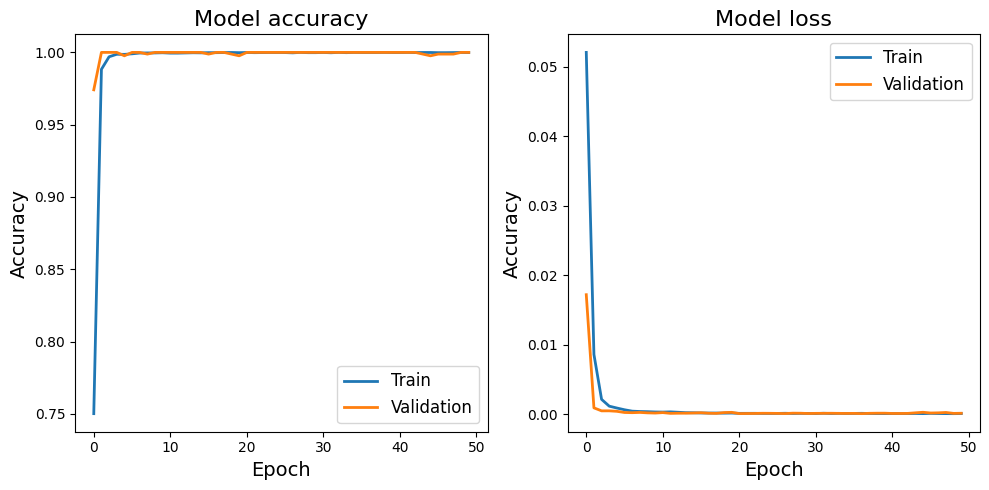

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'], linewidth=2)
plt.plot(history.history['val_accuracy'], linewidth=2)
plt.title('Model accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='lower right',fontsize='large', title_fontsize='large')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Model loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize='large', title_fontsize='large')
plt.tight_layout()
plt.savefig(f'{fig_path}Acc_and_loss_curves_classification.png')
plt.show()

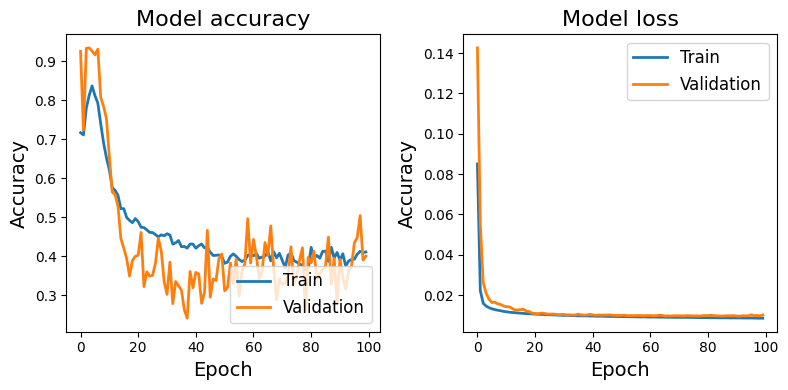

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_phase.history['accuracy'], linewidth=2)
plt.plot(history_phase.history['val_accuracy'], linewidth=2)
plt.title('Model accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='lower right',fontsize='large', title_fontsize='large')
# plt.show()

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_phase.history['loss'], linewidth=2)
plt.plot(history_phase.history['val_loss'], linewidth=2)
plt.title('Model loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize='large', title_fontsize='large')
plt.tight_layout()
plt.savefig(f'{fig_path}Acc_and_loss_curves_detection.png')
plt.show()

### Test data vsulization

In [18]:
phase_model = load_model(f'{save_model_path}EQ_detection_P_and_S_best_model.h5')
test_phase_out = phase_model.predict(X_test_phase)

47/47 [==============================] - 4s 45ms/step


In [57]:
def to_numpy(array):
    array = np.array(array)
    return array


pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(test_phase_out[i, :, 0])
    pre_ind_s = np.argmax(test_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_test_phase[i, :, 0])
    lab_ind_s = np.argmax(y_test_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p = err_indx_p/100
err_indx_s = lab_indx_s - pre_indx_s
err_indx_s = err_indx_s/100

xx = 2
err_indx_p[(err_indx_p > xx) | (err_indx_p < -xx)] = 0
err_indx_s[(err_indx_s > xx) | (err_indx_s < -xx)] = 0

mae_p = np.mean(np.abs(err_indx_p - np.mean(err_indx_p)))
sigma_p = np.std(err_indx_p)
mae_s = np.mean(np.abs(err_indx_s - np.mean(err_indx_s)))
sigma_s = np.std(err_indx_s)

print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s\nMAE and $sigma$ of s: {mae_s:.4f}s\t{sigma_s:.4f}s')

MAE and $sigma$ of p: 0.1467s	0.3440s
MAE and $sigma$ of s: 0.1832s	0.3377s


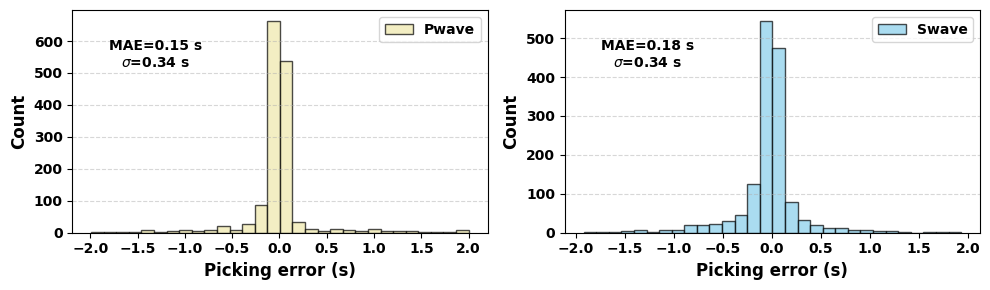

In [58]:
plt.figure(figsize=(10, 3))  # Set figure size
ax = plt.subplot(121)
plt.hist(err_indx_p, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Pwave'], prop={'weight': 'bold'})

ax = plt.subplot(122)
plt.hist(err_indx_s, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_s:.2f} s\n$\sigma$={sigma_s:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Swave'], prop={'weight': 'bold'})

plt.tight_layout()

plt.savefig(f'{fig_path}Arrival_picking_testing_data.png')
plt.show()

(1500, 6000, 2)
ymin, ymax: -0.9118252185580313 1.091039296121811


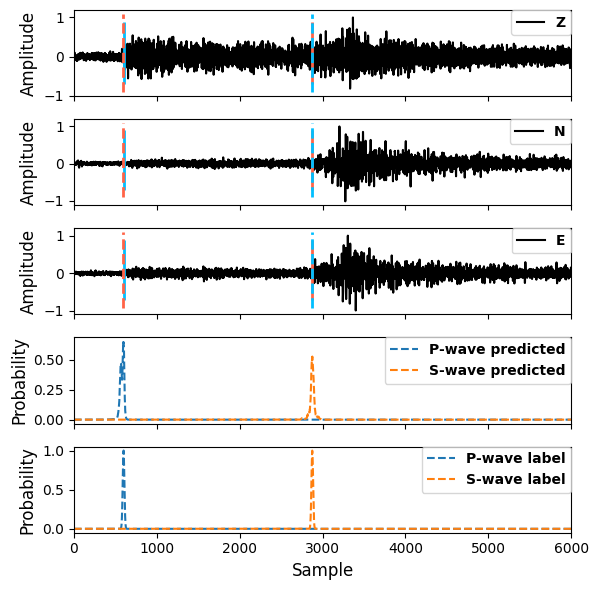

In [27]:
print(test_phase_out.shape)

m = 362

# def plot_labels_signals(signal, p_predict, s_predict, p_labels, s_labels, sample_num):
plot_labels_signals(X_test_phase[m, :, :], p_predict=test_phase_out[m, :, 0], s_predict=test_phase_out[m, :, 1], p_labels=y_test_phase[m, :, 0], s_labels=y_test_phase[m, :, 1], sample_num=6000)
# plt.savefig(f'./figs/phase_picking/p_and_s_wave/p_and_swave_picking_testing_num_{m}.pdf', bbox_inches="tight", dpi=300)
# plt.savefig(f'./figs/phase_picking/p_and_s_wave/p_and_swave_picking_testing_num_{m}.png', bbox_inches="tight", dpi=300)
plt.show()

### Train data visualization

In [28]:
train_phase_out = phase_model.predict(X_train_phase)
print(train_phase_out.shape)

266/266 [==============================] - 6s 24ms/step
(8500, 6000, 2)


In [45]:
pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(train_phase_out[i, :, 0])
    pre_ind_s = np.argmax(train_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_train_phase[i, :, 0])
    lab_ind_s = np.argmax(y_train_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p_train = err_indx_p/100
err_indx_s = lab_indx_s - pre_indx_s
err_indx_s_train = err_indx_s/100


xx = 2
err_indx_p_train[(err_indx_p_train > xx) | (err_indx_p_train < -xx)] = 0
err_indx_s_train[(err_indx_s_train > xx) | (err_indx_s_train < -xx)] = 0
mae_p = np.mean(np.abs(err_indx_p_train - np.mean(err_indx_p_train)))
sigma_p = np.std(err_indx_p_train)
mae_s = np.mean(np.abs(err_indx_s_train - np.mean(err_indx_s_train)))
sigma_s = np.std(err_indx_s_train)


print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s\nMAE and $sigma$ of s: {mae_s:.4f}s\t{sigma_s:.4f}s')

MAE and $sigma$ of p: 0.1184s	0.2809s
MAE and $sigma$ of s: 0.1588s	0.3084s


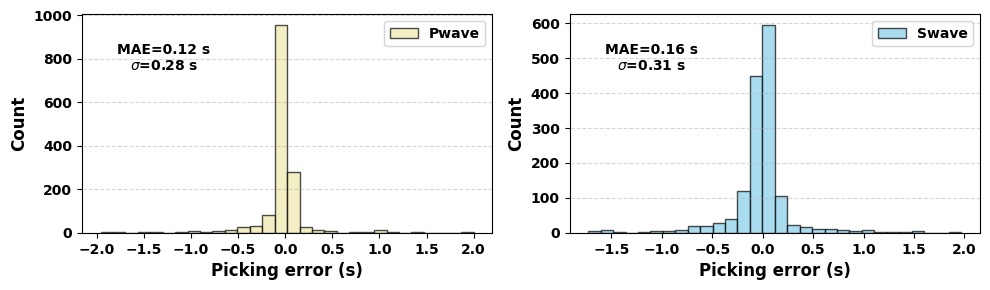

In [47]:
plt.figure(figsize=(10, 3))  # Set figure size
ax = plt.subplot(121)
plt.hist(err_indx_p_train, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Pwave'], prop={'weight': 'bold'})

ax = plt.subplot(122)
plt.hist(err_indx_s_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_s:.2f} s\n$\sigma$={sigma_s:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Swave'], prop={'weight': 'bold'})

plt.tight_layout()

plt.savefig(f'{fig_path}Arrival_picking_training_data.png')
plt.show()

ymin, ymax: -0.9170237752949482 1.0912868464426166


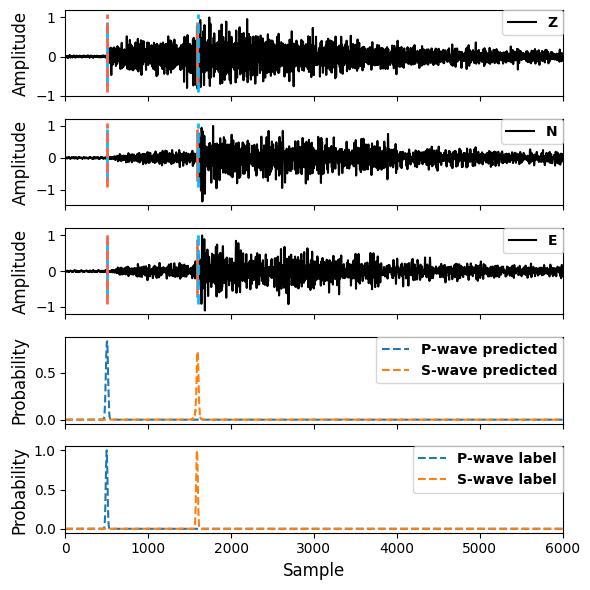

In [48]:
m = 6145

plot_labels_signals(X_train_phase[m, :, :], p_predict=train_phase_out[m, :, 0], s_predict=train_phase_out[m, :, 1], p_labels=y_train_phase[m, :, 0], s_labels=y_train_phase[m, :, 1], sample_num=6000)
plt.show()

In [42]:
# Prediction
# signal predict
model_encoder = load_model(f'{save_model_path}EQ_classification_best_model.h5')
out = model_encoder.predict(X_test_c)

# add threshold
out = class_thres(out, alpha=0.5)


test_labels = y_test_c[:,0]
predicted_classes = out[:,0]

accuracy = accuracy_score(test_labels,predicted_classes)
precision = precision_score(test_labels,predicted_classes)
recall = recall_score(test_labels,predicted_classes)
F1_score1 = 2*precision*recall/(precision+recall)
print(f'The accuracy of the model is {accuracy}, the precision is {precision}, the recall is {recall}, and the F1 scorei is {F1_score1}.')

94/94 [==============================] - 2s 19ms/step
The accuracy of the model is 1.0, the precision is 1.0, the recall is 1.0, and the F1 scorei is 1.0.


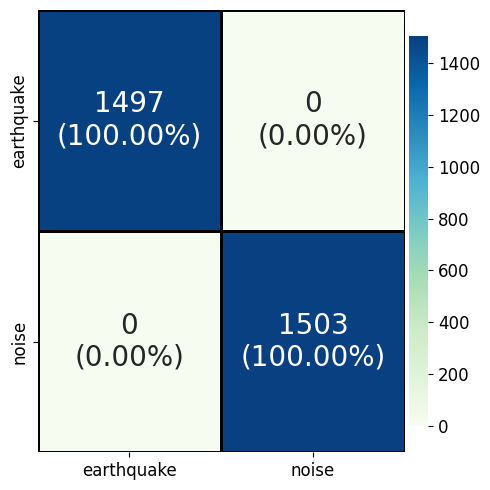

In [55]:
#calculate confusion matrix
import seaborn as sns
C = confusion_matrix(test_labels, predicted_classes)  

custom_labels = ['earthquake', 'noise']

# Create custom annotations with both counts and percentages
confusion_m = C.astype('float') / C.sum(axis=1)[:, np.newaxis]
annotations = np.empty_like(C).astype(str)
n_classes = C.shape[0]
for i in range(n_classes):
    for j in range(n_classes):
        annotations[i, j] = f'{C[i, j]}\n({confusion_m[i, j] * 100:.2f}%)'

# Plot the heatmap with the counts (C) as values for the colorbar
plt.figure(figsize=(5, 5))
ax = sns.heatmap(C, annot=annotations, fmt='', cmap="GnBu", annot_kws={"fontsize": 20}, linewidths=1, linecolor='black', 
                 cbar_kws={"shrink": 1, 'aspect': 20, 'fraction': 0.05, 'pad': 0.01})

# Set x-axis and y-axis labels
ax.set_xticklabels(custom_labels, fontsize=12)
ax.set_yticklabels(custom_labels, fontsize=12, rotation=90)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)


plt.tight_layout()

plt.savefig(f'{fig_path}Classification_testing_data.png')
plt.show()